# OASIS INFOBYTE INTERNSHIP
## DATA SCIENCE

# TASK 4:
## EMAIL SPAM DETECTION WITH MACHINE LEARNING

## IMPORTING LIBRARIES

In [7]:
#For loading the dataset and preprocessing
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import warnings
import re
nltk.download("punkt")
nltk.download('wordnet')
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score, confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# loading data
data = pd.read_csv("spam.csv",encoding = 'latin-1')

In [9]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [11]:
# Dropping some columns
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming the columns
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Exploration

<Axes: xlabel='Target', ylabel='count'>

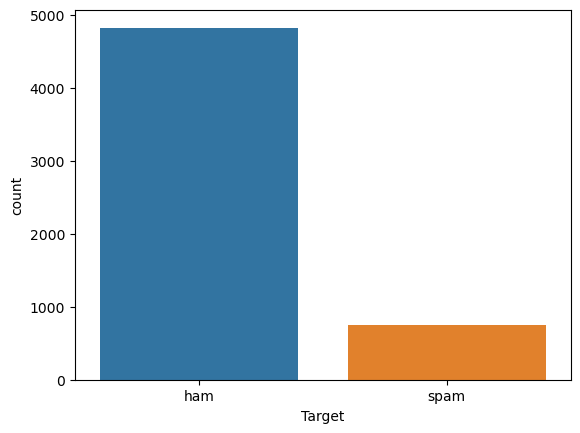

In [12]:
#visualising the number of spam and ham text
sns.countplot(x="Target",data=data)

For data exploration, created a new feature

In [13]:
#Adding a column of numbers of charachters,words and sentences in each message
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"] = data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis =1).apply(len)     
data["No_of_sentence"] = data.apply(lambda row: nltk.sent_tokenize(row["Text"]),axis = 1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


C:\Users\Acer\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

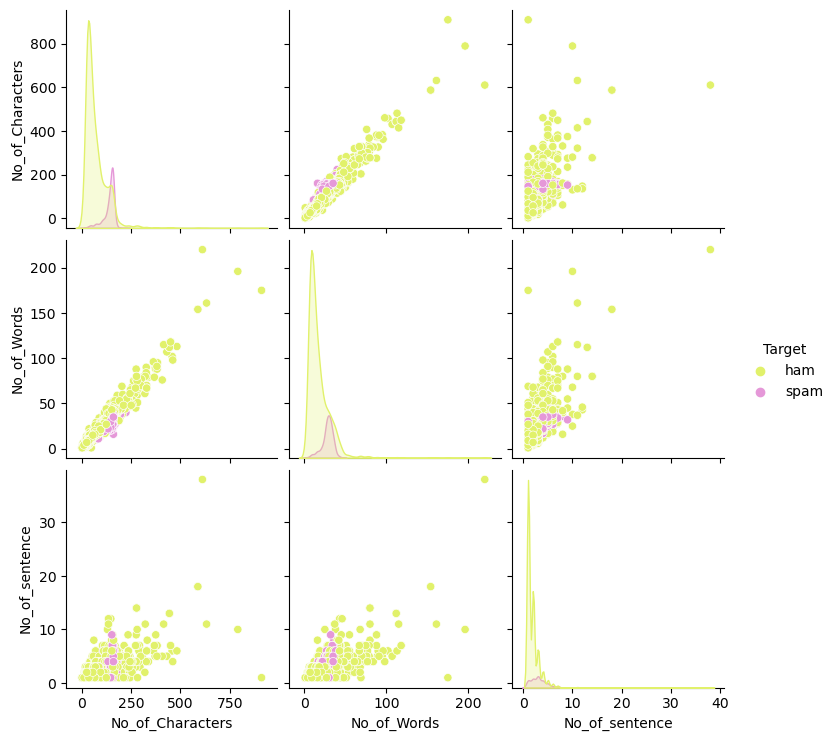

In [14]:
cols= ["#E1F16B", "#E598D8"] 
plt.figure(figsize =(12,8))
fg =sns.pairplot(data = data, hue = "Target", palette = cols)
plt.show(fg)

From the pair plot, we can see a few outliers all in the class ham. This is interesting as we could put a cap over one of these. As they essentially indicate the same thing ie the length of SMS.

In [15]:
#Outlier Detection

#Dropping some outliers
data = data[(data["No_of_Characters"]<350)]
data.shape

(5548, 5)

C:\Users\Acer\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

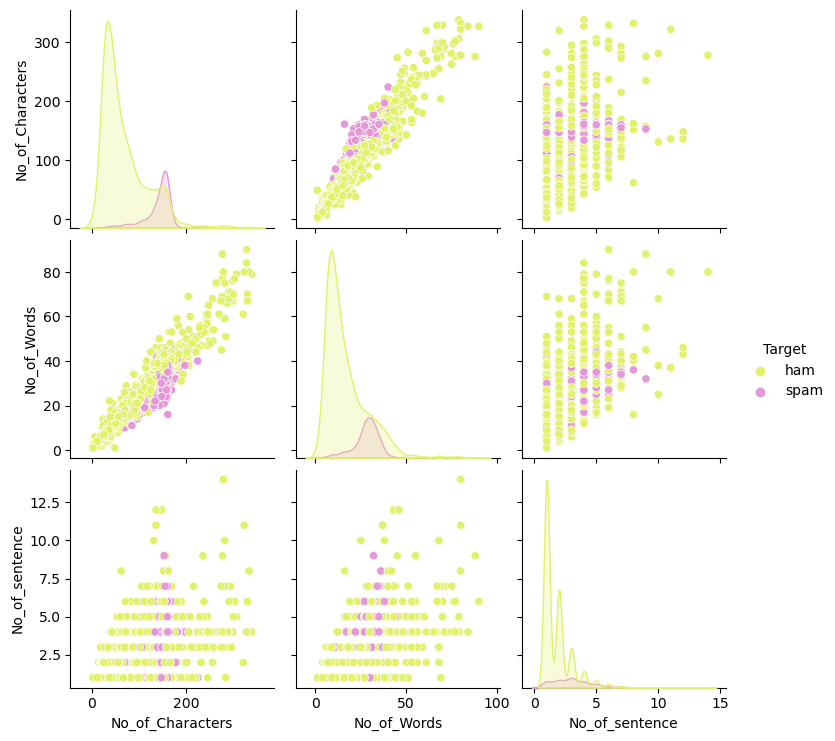

In [16]:
plt.figure(figsize =(12,8))
fg = sns.pairplot(data = data, hue = "Target", palette = cols)
plt.show(fg)

# Data Preprocessing

In [17]:
#Defining a function to clean

def Clean(Text):
    sms = re.sub('[^a-zA-Z]',' ',Text)
    sms = sms.lower()
    sms = sms.split()
    sms = ' '.join(sms)
    return sms
data["Clean_Text"] = data["Text"].apply(Clean)
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [18]:
#Tokenization

data["Tokenize_Text"] = data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis = 1)
print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


In [19]:
#Removing Stopwords
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


In [20]:
#Lemmatization

lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


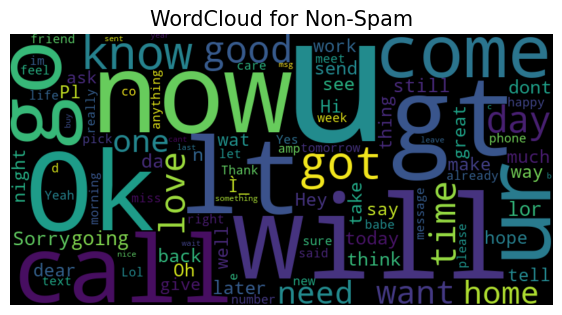

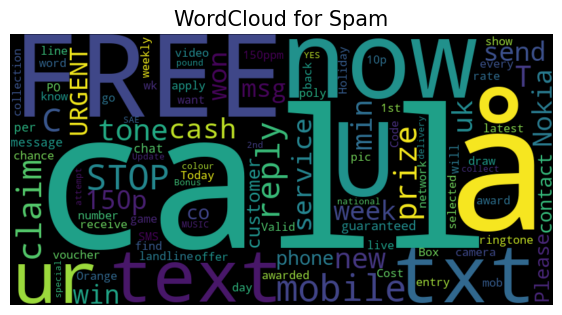

In [21]:
#Visualising the most frequent words in spam and ham text
def wordclouds(data,type):
    text=" ".join(data["Text"])
    plt.figure(figsize=(7,7))
    wc = WordCloud(background_color='black',max_words=100,width=800,height=400,collocations=False).generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {type}', fontsize=15)
    plt.axis('off')
    plt.show()
    
wordclouds(data[data['Target']=="ham"], type='Non-Spam')
wordclouds(data[data['Target']=="spam"], type='Spam')

In [22]:
# Vectorize
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [23]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype

dtype('float64')

In [24]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

# Model Building

Build a pipeline of model for four different classifiers.
1) Naïve Bayes
2) RandomForestClassifier
3) KNeighborsClassifier
4) Support Vector Machines

In [25]:
y = data["Target"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
#Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [27]:
# Cossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.967552 
RandomForest: 0.975890 


C:\Users\Acer\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Acer\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Acer\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Acer\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(

KNeighbours: 0.911450 
SVC: 0.974086 


In [28]:
# Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [29]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [30]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.705882,0.827586,0.974775,0.997521
RandomForest,1.000000,0.823529,0.903226,0.974775,0.997521
KNeighbours,0.977778,0.323529,0.486188,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521


# Thankyou